# Оценка результатов А/В-тестирования нового механизма рекомендаций на сайте интернет-магазина

Цель проекта — провести оценку результатов A/B-теста. В качестве вводных данных есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов. Необходимо оценить корректность проведения теста, проанализировать результаты теста, исследовать пересечение тестовой аудитории с конкурирующим тестом, совпадение теста и маркетинговых событий, а также другие проблемы временных границ теста.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

# Загрузка данных, предобработка

In [1]:
# Загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
import datetime  
import scipy.stats as st
import math as mth
from datetime import datetime, timedelta

# устанавливаем отображение количества столбцов экране 
pd.options.display.max_columns = 40
pd.options.display.max_colwidth = 150
pd.options.display.float_format = '{:.2f}'.format # устанавливаем отображение числа знаков после точки.
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Загружем дата сеты
try:
    dfme= pd.read_csv('ab_project_marketing_events.csv', parse_dates=['start_dt', 'finish_dt'])
except:
    dfme= pd.read_csv('/datasets/ab_project_marketing_events.csv', parse_dates=['start_dt', 'finish_dt'])

try:
    dfnu = pd.read_csv('final_ab_new_users.csv', parse_dates=['first_date'])
except:
    dfnu = pd.read_csv('/datasets/final_ab_new_users.csv', parse_dates=['first_date'])     

try:
    dfe = pd.read_csv('final_ab_events.csv', parse_dates=['event_dt'])
except:
    dfe = pd.read_csv('/datasets/final_ab_events.csv', parse_dates=['event_dt']) 
    
try:
    dfp = pd.read_csv('final_ab_participants.csv')
except:
    dfp = pd.read_csv('/datasets/final_ab_participants.csv') 

In [4]:
print('Календарь маркетинговых событий на 2020 год:\n')
dfme.info()
dfme

Календарь маркетинговых событий на 2020 год:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [5]:
print('Пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года:\n')
dfnu.info()
dfnu.head()

Пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
print('Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:\n')
dfe.info()
dfe.head()

Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [7]:
print('Таблица участников тестов:\n')
dfp.info()
dfp.head()

Таблица участников тестов:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


## Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

**Этапы предобработки:**
- Преобразовать данные времени к нужному типу (сделано при загрузке);
- Проверить таблицы на пропуски и на наличие дубликатов;
- Произвести проверку: все ли пользователи участвовали в тестировании только будучи в одной группе

In [8]:
# Проверка таблицы на пропуски и  наличие явных дубликатов;
data = [dfme, dfnu, dfe, dfp]

for i in data:
    print('Количество дубликатов:')
    print(i.duplicated().sum())
    print('Количество пропусков:')
    print(i.isna().sum(),'\n')

Количество дубликатов:
0
Количество пропусков:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64 

Количество дубликатов:
0
Количество пропусков:
user_id       0
first_date    0
region        0
device        0
dtype: int64 

Количество дубликатов:
0
Количество пропусков:
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64 

Количество дубликатов:
0
Количество пропусков:
user_id    0
group      0
ab_test    0
dtype: int64 



Из информации по таблицам видно, что только в таблице `dfe` в столбце `details` присутствуют пропущенные значения. Предполагаю, что клиент, который совершал покупки `purchase` имеет значения в `details`. Сгруппируем значения и посмотрим верна ли теория

In [9]:
dfe.groupby('event_name')['details'].count()

event_name
login               0
product_cart        0
product_page        0
purchase        62740
Name: details, dtype: int64

Данные в столбце `details` заполнены, если только в столбце `event_name` значение `purchase`.Теория верна. Пустые значения оставляем в колонке `details`, они обоснованы.

In [10]:
# функция для проверки  неявных дубликатов
def dup(df, column, n=5):
    res = df[column].value_counts().head(n)
    return res

In [11]:
# проверка на наличие неявных дубликатов таблицы marketing_events
for col in dfme.columns:
    print(dup(dfme, col, n=5))

Christmas&New Year Promo        1
St. Valentine's Day Giveaway    1
St. Patric's Day Promo          1
Easter Promo                    1
4th of July Promo               1
Name: name, dtype: int64
APAC                        4
EU, CIS, APAC, N.America    3
EU, N.America               2
EU, CIS, APAC               2
CIS                         2
Name: regions, dtype: int64
2020-12-25    1
2020-02-14    1
2020-03-17    1
2020-04-12    1
2020-07-04    1
Name: start_dt, dtype: int64
2021-01-03    1
2020-02-16    1
2020-03-19    1
2020-04-19    1
2020-07-11    1
Name: finish_dt, dtype: int64


In [12]:
# проверка на наличие неявных дубликатов таблицы new_users
for col in dfnu.columns:
    print(dup(dfnu, col, n=5))

D72A72121175D8BE    1
A25EF6D0E025C48E    1
62B9FD1B8BDB669C    1
9A5F371EED469627    1
2DF6B79FC97641EC    1
Name: user_id, dtype: int64
2020-12-21    6290
2020-12-14    5654
2020-12-07    5595
2020-12-13    4691
2020-12-20    4288
Name: first_date, dtype: int64
EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64
Android    27520
PC         15599
iPhone     12530
Mac         6084
Name: device, dtype: int64


In [13]:
# проверка на наличие неявных дубликатов таблицы events
for col in dfe.columns:
    print(dup(dfe, col, n=5))

A3917F81482141F2    36
D6477068EF132236    32
8AEB716C4CD82CA7    32
590DACD07A839BC3    32
3356239C0DC75E2A    32
Name: user_id, dtype: int64
2020-12-23 02:37:24    10
2020-12-14 18:54:55    10
2020-12-20 02:51:18     9
2020-12-24 00:54:52     9
2020-12-13 06:00:54     9
Name: event_dt, dtype: int64
login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64
4.99      46362
9.99       9530
99.99      5631
499.99     1217
Name: details, dtype: int64


In [14]:
# проверка на наличие неявных дубликатов таблицы participants
for col in dfp.columns:
    print(dup(dfp, col, n=5))

0FDFDA0B2DEC2D91    2
00E68F103C66C1F7    2
BD23AF6242CA944B    2
DD670F7422342729    2
A5E27D8BCACA668E    2
Name: user_id, dtype: int64
A    9655
B    8613
Name: group, dtype: int64
interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64


Явные дубликаты отсутствуют. Не явные дубликаты, на которые стоит обратить внимание - в столбце `user_id` таблицы `participants`. Возможно некоторые пользователи попали в две группы теста.

**Вывод:**
- Нарушение стиля в названиях столбцов отсутствует;
- Преобразовать данные времени к нужному типу DateTime;
- Явных дубликатов не обнаружено;
- В столбце user_id таблицы participants были обнаружены неявные дубликаты, это может говорить о том, что возможно некоторые пользователи попали в две группы теста;
- В столбцах details таблицы events были обнаружены пропущенные значения, которые так же соответствуют данным и были сохранены.


# Оценка корректности проведения теста. 

### Проверка соответствия и коректности данных требованиям технического задания

Объединим таблицы `new_users` , `events` и `participants`. Далее для проверки понадобятся данные из этих датафреймов  

In [15]:
df = dfnu.merge(dfe, how='outer', on='user_id')
data = df.merge(dfp, how='outer', on='user_id')
data.head()

,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:10,product_page,NaN,A,recommender_system_test
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,NaN,A,recommender_system_test
2,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-07 16:38:09,product_page,NaN,NaN,NaN
3,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-08 02:02:34,product_page,NaN,NaN,NaN
4,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-23 14:35:41,product_page,NaN,NaN,NaN


**Название теста: `recommender_system_test`**

In [16]:
ab_test = data.query('ab_test == "recommender_system_test"')
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27724 entries, 0 to 449831
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     27724 non-null  object        
 1   first_date  27724 non-null  datetime64[ns]
 2   region      27724 non-null  object        
 3   device      27724 non-null  object        
 4   event_dt    24698 non-null  datetime64[ns]
 5   event_name  24698 non-null  object        
 6   details     3331 non-null   float64       
 7   group       27724 non-null  object        
 8   ab_test     27724 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 2.1+ MB


**группы: А — контрольная, B — новая платёжная воронка**

In [17]:
# проверка равномерности распределения пользователей на группы A и B после объединения таблиц
ab_test.groupby(['group', 'ab_test']).agg({'user_id': 'nunique'}).query('ab_test == "recommender_system_test"')

,,user_id
group,ab_test,
A,recommender_system_test,3824
B,recommender_system_test,2877


По количеству участников группы сформированы не равномерно. Неравномерное формирование в группах может привести к  погрешности в результатах теста.

**Дата запуска: 2020-12-07**

In [18]:
#дата запуска: 2020-12-07;
ab_test['first_date'].value_counts()

2020-12-14    3680
2020-12-21    3404
2020-12-07    2790
2020-12-20    2263
2020-12-18    2080
2020-12-16    1980
2020-12-19    1959
2020-12-15    1911
2020-12-17    1864
2020-12-09    1199
2020-12-08    1168
2020-12-12     986
2020-12-13     826
2020-12-11     811
2020-12-10     803
Name: first_date, dtype: int64

Не все пользователи теста зарегистрировались 2020-12-07, некоторые позже.

**Дата остановки набора новых пользователей: 2020-12-21**

In [19]:
ab_test['first_date'].max()

Timestamp('2020-12-21 00:00:00')

Дата остановки набора новых пользователей соответствует ТЗ.

**Дата остановки: 2021-01-04**

In [20]:
ab_test['event_dt'].max()

Timestamp('2020-12-30 12:42:57')

Завершение самого позднего события не совподает (от 4 января, 2021). Из этого следует, что тест выполнен не до конца по какой-либо причине, либо происходила длительная задержка между совершением событий пользователем и занесением информации о его активности в таблицу

**Аудитория: 15% новых пользователей из региона EU**

In [21]:
# число пользователей из EU
df_eu = ab_test.groupby('region').agg({'user_id': 'nunique'}).query('region == "EU"').reset_index()
df_eu_new =  dfnu.groupby('region').agg({'user_id': 'nunique'}).query('region == "EU"').reset_index()

# расчет доли пользователей из EU
per = (df_eu['user_id']/ df_eu_new['user_id'] * 100).round(1)

per

0   13.70
Name: user_id, dtype: float64

Аудитория составляет 13,7 %, что не соответсвует ТЗ

**Ожидаемое количество участников теста: 6000**

In [22]:
ab_test['user_id'].nunique()

6701

Ожидаемое количество участников теста превышает 6000, что соответствует ТЗ.

**Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:**
- конверсии в просмотр карточек товаров — событие `product_page`,
- просмотры корзины — `product_cart`,
- покупки — `purchase`.

In [23]:
#добавляем к таблице колонку last_test_date, она определяем горизонт для ресчета эффекта по каждому пользователю
ab_test['last_test_date'] = (ab_test['first_date'] + timedelta(days=14))
print(ab_test['last_test_date'].min(), ab_test['last_test_date'].max())

2020-12-21 00:00:00 2021-01-04 00:00:00


In [24]:
#У нас отсутствуют данные о событиях после 2020-12-30 поэтому определяем дату последней регистрации, 
# которая будет приемлема для расчета эффективности
ab_test['last_reg_date'] = (ab_test['event_dt'].max() - timedelta(days=13))
ab_test.head(2)

,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test,last_test_date,last_reg_date
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:10,product_page,NaN,A,recommender_system_test,2020-12-21,2020-12-17 12:42:57
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,NaN,A,recommender_system_test,2020-12-21,2020-12-17 12:42:57


In [25]:
#делаем выборку по пользователям и событиям, подходящим под критерий расчета эффективности за 14 дней

test_data = ab_test[(ab_test['first_date'] <= ab_test['last_reg_date']) & (ab_test['event_dt'] <= ab_test['last_test_date'])]

print('Диапазон дат событий:\n', test_data['event_dt'].min(), test_data['event_dt'].max())

Диапазон дат событий:
 2020-12-07 00:05:57 2020-12-29 23:01:19


Сейчас у нас есть пользователи, которые были активны в течении 14 дней. Разобьем пользователей на группы А и В, посчитаем их в каждой группе по колонке `event_name` 

In [26]:
test_data = test_data.pivot_table(index='group', columns='event_name', values = 'user_id', aggfunc = 'nunique')
test_data

event_name,login,product_cart,product_page,purchase
group,,,,
A,1597,479,1018,487
B,674,195,386,189


In [27]:
# создадим df  расчетом конверсии в целевые действия
test_df = pd.DataFrame() 
test_df['product_cart'] = test_data['product_cart'] / test_data['login']
test_df['product_page'] = test_data['product_page'] / test_data['login']
test_df['purchase'] = test_data['purchase'] / test_data['login']

test_df.T

group,A,B
product_cart,0.30,0.29
product_page,0.64,0.57
purchase,0.30,0.28


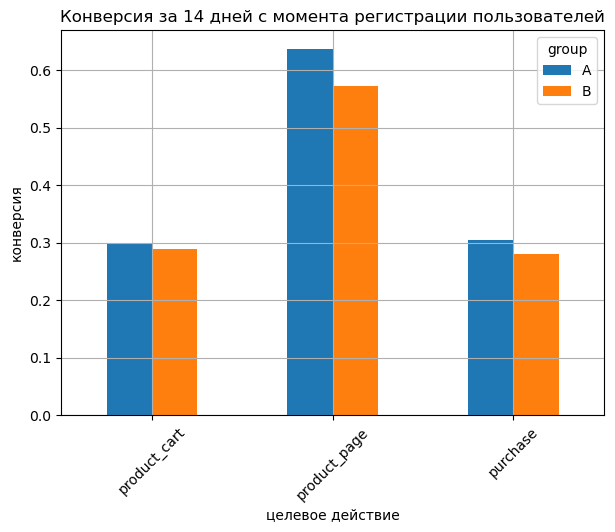

In [28]:
# строим столбчатую диаграмму для визуализации конверсии по целевым метрикам
test_df.T.plot(kind='bar', grid=True, title = ('Конверсия за 14 дней с момента регистрации пользователей'), figsize = (7, 5)\
     , xlabel = ('целевое действие'), ylabel = 'конверсия')
plt.xticks(rotation = 45)
plt.show()

Итог от ожидаемог эффекта за 14 дней:
- эффект, ожидавшийся от эксперимента, не достигнут
- по факту тестовая группа показала ухудшение конверсии относительно контрольной

**Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.**

In [29]:
dfme_focus = dfme[dfme['finish_dt'] > '2020-12-07']
dfme_focus

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


По датам и по региону проведения тест совпадает с новогодними акциями-  может исказить результаты теста

**Аудиторию теста. Удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах  теста одновременно.Проверьте равномерность распределения по тестовым группам и правильность их формирования**

Определим, чтобы каждый пользователь состоял только в одной группе в одном тесте:

In [30]:
# сгруппируем пользователей по количеству уникальных для них групп:
multi_visitors = data.groupby(['user_id', 'ab_test'])['group'].nunique().reset_index()

#оставим пользователей только с количеством групп больше одной:
multi_visitors = multi_visitors[multi_visitors['group']>1]

print('Количество пользователей, участвующих в двух группах теста одновременно:', multi_visitors.shape[0])

Количество пользователей, участвующих в двух группах теста одновременно: 0


Определим, что нет пересечений с конкурирующим тестом

In [31]:
# ответ на комментарий ревьювера
multi_group = data.groupby(['user_id'])['group'].nunique().reset_index()
multi_group = multi_group[multi_group['group']>1]
multi_users = multi_group['user_id'].unique()

print('Количество пользователей, которые участвовали в двух группах в разных тестах:', multi_users.shape[0])
print('Процент пользователей, которые участвовали в двух группах в разных тестах:', round(((multi_users.shape[0]*100)/ab_test['user_id'].nunique()),2))

Количество пользователей, которые участвовали в двух группах в разных тестах: 776
Процент пользователей, которые участвовали в двух группах в разных тестах: 11.58


Проверь пересечение по тестам. Может ли пересечение с другим тестом повлиять на результаты?

In [32]:
# подсчет пользователей, попавших в оба теста
tests = data.groupby('user_id').agg({'ab_test': 'nunique'}).query('ab_test == 2').count()
print(f'Пользователи, попавшие в оба теста:{tests}')

# подсчет уникальных пользователей
uni = len(data['user_id'].unique())
print(f'Количество уникальных пользователей: {uni}')

# процент пользователей, попавших в оба теста
print(f'Пользователи попавшие в оба теста: {(tests / uni) * 100}')

Пользователи, попавшие в оба теста:ab_test    1602
dtype: int64
Количество уникальных пользователей: 61733
Пользователи попавшие в оба теста: ab_test   2.60
dtype: float64


In [33]:
#равномерность распределения по тестовым группам и правильность их формирования.
ab = data.groupby(['ab_test','group'], as_index=False)['user_id'].nunique()

print('Распределение пользователей по тестовым группам:\n', ab)

Распределение пользователей по тестовым группам:
                    ab_test group  user_id
0        interface_eu_test     A     5831
1        interface_eu_test     B     5736
2  recommender_system_test     A     3824
3  recommender_system_test     B     2877


В группе В в двух группах значения меньше 

- По количеству участников группы сформированы не равномерно. Неравномерное формирование в группах может привести к  погрешности в результатах теста.
- Не все пользователи теста зарегистрировались 2020-12-07, некоторые позже.
- Дата остановки набора новых пользователей соответствует ТЗ.
- Дата остановки не соответствует ТЗ
- Аудитория составляет 13,7 %, что не соответсвует ТЗ
- Ожидаемое количество участников теста превышает 6000, что соответствует ТЗ.
- Итог от ожидаемог эффекта за 14 дней:
  - эффект, ожидавшийся от эксперимента, не достигнут
  - по факту тестовая группа показала ухудшение конверсии относительно контрольной
- По датам и по региону проведения тест совпадает с новогодними акциями-  может исказить результаты теста

Это хорошо, что каждый пользователь состоял только в одной группе в одном тесте. Проверим равномерность распределения по тестовым группам и правильность их формирования

**Вывод:**

Данные, которые не соответствуют ТЗ:
- Неравномерное формирование в группах может привести к погрешности в результатах теста;
- Не все пользователи теста зарегистрировались 2020-12-07;
- Дата остановки теста не соответствует;
- Аудитория составляет 13,7 %, что не соответствует ТЗ;
- эффект, ожидавшийся от эксперимента, не достигнут. По факту тестовая группа показала ухудшение конверсии относительно контрольной группы;
- Данные попадают так же в дни новогодних акции. Это может исказить результат.

Данные, которые соответствуют ТЗ:
- Дата остановки набора новых пользователей соответствует ТЗ;
- Ожидаемое количество участников теста превышает 6000;
- Каждый пользователь состоял только в одной группе в одном тесте. 




# Исследовательский анализ данных

**Распределение количества событий на одного пользователя**

Определим сколько в среднем событий приходится на пользователя:

In [34]:
df_event = ab_test.groupby(['user_id', 'group'])['event_name'].count()
df_event = df_event.reset_index()
df_event_mean = round(df_event['event_name'].mean(),2)

print('Среднее количество событий, которые приходятся на одного пользователя:', df_event_mean)
df_event.head()

Среднее количество событий, которые приходятся на одного пользователя: 3.69


,user_id,group,event_name
0,000ABE35EE11412F,A,0
1,001064FEAAB631A1,B,6
2,0010A1C096941592,A,12
3,001C05E87D336C59,A,0
4,00341D8401F0F665,A,2


Из данных видно, что есть пользователи, которые совершали и 12 событий и 6 и 0. Следует что количество событий на одного человека не равномерно. Так же отметим что есть 0, значит не все пользователи совершали действия 

In [35]:
# Посмотрим скоолько пользователей совершили каждое из событий
df_group = ab_test.groupby(['group','event_name']).agg({'user_id':'nunique'}).sort_values(
    by = 'user_id', ascending = False
).reset_index()
df_group

,group,event_name,user_id
0,A,login,2747
1,A,product_page,1780
2,B,login,928
3,A,purchase,872
4,A,product_cart,824
5,B,product_page,523
6,B,purchase,256
7,B,product_cart,255


Рассмотрим подробнее изучить распределение количества событий на пользователя в разрезе групп. Построим гистограмму распределения. Анализ результатов A/B теста всегда стоит проводить в разрезе групп, так как мы сравниваем их между собой.

In [ ]:
# Гистограмма в разрезе групп
fig = px.histogram(df_event, x="event_name", color="group")
fig.show()

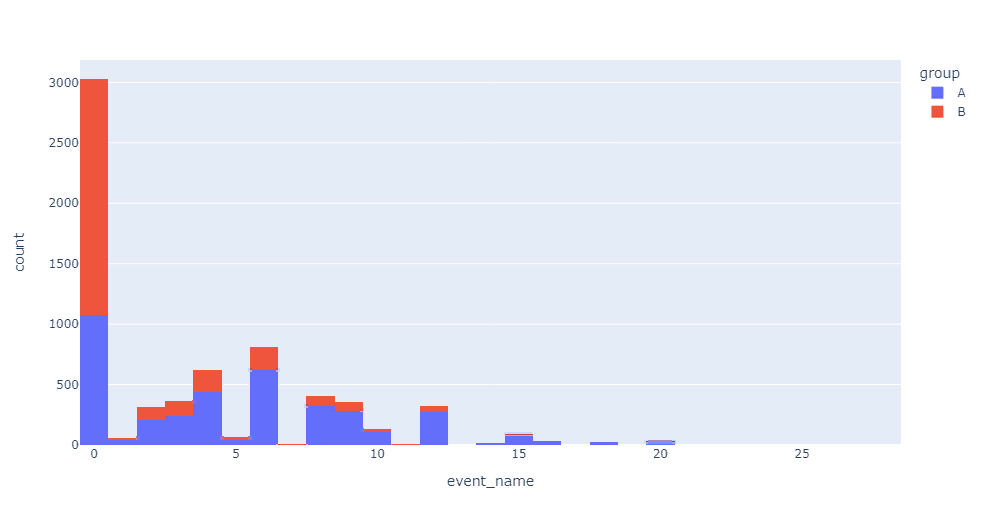

Среди участников группы B больше, тех кто не совершал действия = 0 (1949 участников.) Притом мы выяснили, что участников в группе В меньше, это очень плохой показатель.

**Распределение числа событий в выборках по дням**

Определим среднее количество посещений в день:

In [38]:
# Для дальнейшей работы создадим комию и переведем время в нужный формат 
days = ab_test.copy()
days['event_dt'] = days['event_dt'].dt.strftime('%d %b')

In [39]:
#Количество посещений по группам
event_day = days.groupby(['event_dt','group'])['user_id'].count().to_frame().reset_index()
#Среднее количество посещений в день 
event_day_all = days.groupby(['event_dt'])['user_id'].count().to_frame()
print('Среднее количество посещений в день пользователями:', round(event_day_all['user_id'].mean()))

Среднее количество посещений в день пользователями: 1029


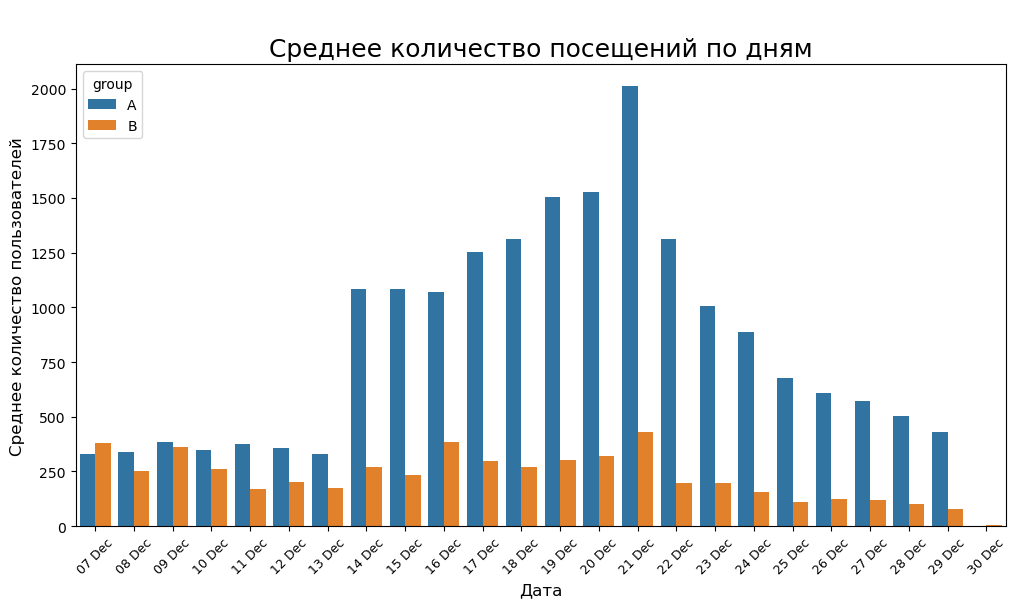

In [40]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x='event_dt', y="user_id", data=event_day, hue='group', estimator=np.mean)
plt.title('\nСреднее количество посещений по дням', fontsize=18)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Среднее количество пользователей', fontsize=12)
plt.xticks(rotation = 45,fontsize = 9)
plt.show()

В начале теста активность пользователей из группы В была близка к активности к группе А (притом, что выборки не равномерны). Но после 14 декабря резкое увеличение активности группы А, а тенденция группы В чуть усела или даже немного сократилась

**Изминение конверсии в воронке в выборках на разных этапах**

Отсортируем события по числу пользователей. Также посчитаем долю пользователей, которые хоть раз совершали событие:

In [41]:
# Посчитаем количество совершенных событий пользователями и количество уникальных пользователей каждого события по группам:
data_event = days.groupby(['event_name', 'group'])[['user_id']].agg({'user_id': ['count', 'nunique']})
data_event.columns = data_event.columns.droplevel(0)
data_event = data_event.reset_index()

# поменяем последовательность индексов для создания правильной хроналогии событий покупки:
data_event = data_event.reindex(index=[0,1,4,5,2,3,6,7])

# посчитаем долю пользователей, которые хоть раз совершали каждое событие по отдельности 
# и выведем полученную информацию на экран отдельно по группам:
for group in ['A', 'B']: 
    data_event.loc[data_event['group']==group, 'ratio'] = round(data_event[data_event['group']==group]['nunique']*100 / 
                                                            days[days['group']==group]['user_id'].nunique(),2)    
    data_event_group = data_event[data_event['group']==group]
    print(data_event_group)
    print( )

     event_name group  count  nunique  ratio
0         login     A   8566     2747  71.84
4  product_page     A   5525     1780  46.55
2  product_cart     A   2558      824  21.55
6      purchase     A   2655      872  22.80

     event_name group  count  nunique  ratio
1         login     B   2624      928  32.26
5  product_page     B   1405      523  18.18
3  product_cart     B    689      255   8.86
7      purchase     B    676      256   8.90



Построим воронку событий со значением конвертации в процентах

In [ ]:
fig = go.Figure()
fig.update_layout(title="Воронка событий")    
fig.add_trace(go.Funnel(name = 'A',textinfo = "text+percent initial", text = data_event[data_event['group']=='A']['nunique'],
                        y = data_event[data_event['group']=='A']['event_name'].tolist(),
                        x = data_event[data_event['group']=='A']['ratio'].tolist()))       

fig.add_trace(go.Funnel(name = 'B',textinfo = "text+percent initial", text = data_event[data_event['group']=='B']['nunique'],
                        y = data_event[data_event['group']=='B']['event_name'].tolist(),
                        x = data_event[data_event['group']=='B']['ratio'].tolist()))
fig.show()

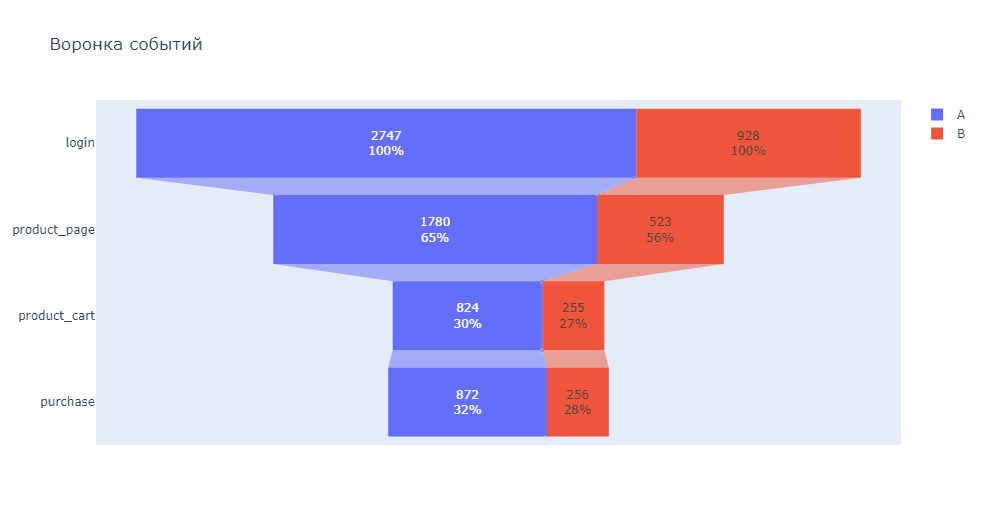

Согласно воронке порядок событий следующий:

`login` - регистрация,

`product_page` - просмотр карточек товаров,

`product_cart` - просмотр корзины товаров,

`purchase` - покупка

По ТЗ группа В должна быть больше, но по факту это не так. Показатели  группы А выше чем аналогичные показатели у группы В.

Посчитаем , доли пользователей которые проходят на следующий шаг воронки от числа пользователей на предыдущем по каждой группе

In [43]:
df_proportion = days.groupby(['user_id', 'group'])['event_name'].nunique().reset_index() # группируем по количеству 
# событий для каждого пользователя
df_proportion = df_proportion[df_proportion['event_name']==4]


print('Для группы А:')
print('Доля пользователей, которая проходит от первого события  до оплаты от общего числа клиентов', 
      round(df_proportion[df_proportion['group']=='A'].shape[0] / days['user_id'].nunique(), 4))
print()
print('Для группы В:')
print('Доля пользователей, которая проходит от первого события  до оплаты от общего числа клиентов', 
      round(df_proportion[df_proportion['group']=='B'].shape[0] / days['user_id'].nunique(), 4))

Для группы А:
Доля пользователей, которая проходит от первого события  до оплаты от общего числа клиентов 0.0263

Для группы В:
Доля пользователей, которая проходит от первого события  до оплаты от общего числа клиентов 0.0073


В группе А доля пользователей, которая проходит от первого события до оплаты от общего числа клиентов, примерно в 3,5 раза выше чем у группы В. Тестовое задание не удачное решение

**Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию**

- Было запущено два теста одновременно, мы оставили участников только нужного (даже с учетом, что некоторые входили в оба теста). Нужно исключать пересечения пользователей из разных тестов;
- Группа А имеет перевес по количеству пользователей;
- Количество пользователей для теста - важность количества пользователей для корректности проведения теста;
- У нас нет данных с 30-го декабря и по 4 января;

**Выводы:**
- Количество событий на пользователя в выборках распределено неравномерно.
- пользователи добавляют товар в корзину в меньшей степени, чем совершают покупок
- В начале теста активность пользователей из группы В была близка к активности к группе А (притом, что выборки не равномерны). Но после 14 декабря резкое увеличение активности группы А, а тенденция группы В чуть усела или даже немного сократилась
- По ТЗ группа В должна быть больше, но по факту это не так. Показатели группы А выше чем аналогичные показатели у группы В.
- Конверсия - Группа В дает показатели хуже на каждом этапе воронки, чем группа А.

# Оценка результаты A/B-тестирования

**Что можно сказать про результаты A/В-тестирования?**

- Результат теста показывает, что группа В хуже по значениям конверсии, чем группа А. 
- Ожидаемых результатов не достигнуто, а наборот, старая платежная система показала себя лучше на каждом этапе хоть и незначительно;
- Согласно ТЗ тест должен закончиться 4 января 2021 года, но по факту он завершился 30 декабря в связи с неполными исходными данными. Таким образом существует проблема с необходимым объемом выборки и длительностью проведения эксперимента. 
- Стоило ли проводит тестирование в канун новогодних праздников. Хоть влияние данных событий было незначительно, все-таки стиот избегать проведение теста в момент крупных праздников
- Делать выводы о том, что мы имее резултаты еще рано.

С целью получения максимально достоверных результатов теста нужно продолжить исследование, взяв более длительный промежуток для анализа с учетом сохранения текущего посещения пользователей

**Проверим статистическую разницу долей z-критерием.**

Создадим необходимые таблицы для исследования долей:

In [44]:
# Количество уникальных пользователей в каждой группе:
users = days.groupby('group')['user_id'].nunique()

# Количество уникальных пользователей в каждом этапе:
funnel = days.pivot_table(index='event_name', values='user_id', columns='group',aggfunc=lambda x: len(x.unique()))
funnel = funnel.reset_index().sort_values(by='A', ascending=False)

users

group
A    3824
B    2877
Name: user_id, dtype: int64

In [45]:
 funnel

group,event_name,A,B
0,login,2747,928
2,product_page,1780,523
3,purchase,872,256
1,product_cart,824,255


Составим функцию которая позволит нам проверять статистическую разницу между выборками A-B.Применим поправку Бонферрони - поделим альфа на количество гипотиз-4.

Обозначу нулевую и альтернативную гипотезы, а также примем alpha=0.05

**Н0 - доли уникальных посетителей, побывавших на этапе воронки, в группах А и B одинаковы;**

**Н1 - между долями уникальных посетителей, побывавших на этапе воронки, в группах A и B различие есть.**

In [46]:
# создаем функцию определения статистической значимости  различий в 3-х группах
def AB_test(purchasesA ,purchasesB ,leadsA ,leadsB , eventname, alpha = 0.05/4):
    # пропорция успехов в первой группе:
    p1 = purchasesA/leadsA
    # пропорция успехов во второй группе:
    p2 = purchasesB/leadsB
    # пропорция успехов в комбинированном датасете:
    p_combined = (purchasesA + purchasesB) / (leadsA + leadsB)
    # разница пропорций в датасетах
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leadsA + 1/leadsB))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value =(1 - distr.cdf(abs(z_value))) * 2
    print(f'Расчет теста для действия пользователей {eventname}')
    print('p-значение: ', p_value)

    if p_value < alpha:

        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print(' ')

In [47]:
test_AB = [AB_test(funnel['A'][i],funnel['B'][i],users['A'], users['B'],funnel['event_name'][i], alpha =  0.05/len(funnel['A'])) for i in range(len(funnel['A']))]

Расчет теста для действия пользователей login
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
Расчет теста для действия пользователей product_cart
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
Расчет теста для действия пользователей product_page
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
Расчет теста для действия пользователей purchase
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


группа А по всем показателям лучше группы B. Создадим дата-фрейм, где сравним две доли, чтобы убедиться в правильности z-теста

In [48]:
x = funnel.iloc[0:4, 0:3]
x.loc[:, 'A'] = x['A'] / users['A']
x.loc[:, 'B'] = x['B'] / users['B']
    
x['diff'] = abs(x['A'] - x['B'])

x

group,event_name,A,B,diff
0,login,0.72,0.32,0.40
2,product_page,0.47,0.18,0.28
3,purchase,0.23,0.09,0.14
1,product_cart,0.22,0.09,0.13


- Уровень значимости был выбран при проверке статистических гипотез равный 0,05;
- Нет смысла менять уровень значимости с текущего значения на другой, потому что данное действие сильно выводы с проведенных раннее тестов не изменит и конечный результат всего исследования не поменяет

# Выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования.

**Соответствие данных требованиям технического задания:**

*Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;* 

*Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%*

Данные, которые не соответствуют ТЗ:
- Неравномерное формирование в группах может привести к погрешности в результатах теста;
- Не все пользователи теста зарегистрировались 2020-12-07;
- Дата остановки теста не соответствует;
- Аудитория составляет 13,7 % EU, что не соответствует ТЗ;
- Данные попадают так же в дни новогодних акции. Это может исказить результат.

Данные, которые соответствуют ТЗ:
- Дата остановки набора новых пользователей соответствует ТЗ;
- Ожидаемое количество участников теста превышает 6000;

- Действия некоторых пользователей приходятся на маркетинговое событие `Christmas&New Year Promo(с 2020-12-25 по 2021-01-03)` и `CIS New Year Gift Lottery ( с 2020-12-30 по 2021-01-07)`, что могло повлиять на изменение конверсии и корректность проведения А/В-теста. События по группам А и В распределены неравномерно, в группе А значительно больше событий по сравнению с группой В.
- Пользователи, попавшие в оба теста нет ;
- А пользователи, попавшие в обе группы теста составляют менее 16 % (пользователи из разных тестов) 
- Пользователи по группам исследуемого теста распределены не слишком равномерно.

**Исследовательский анализ данных:**

- Стоит отметить что  изменилась последовательность действий, пользователи добавляют товар в корзину в меньшей степени, чем совершают покупок, это говорит о том, что воронка событий - простая, то есть не имеет строгой последовательности действий.
- Конверсия - Группа В дает показатели хуже на каждом этапе воронки, чем группа А.
- По ТЗ группа В должна быть больше, но по факту это не так. Показатели группы А выше чем аналогичные показатели у группы В.

**Оценка результатов A/B-тестирования:**
- Нет преобладания группы В над А. Скорее группа А показывает лучшие показатели конверсии, чем эксперементальная группа;
- Корректность проведения теста, исходя из условий проведения, не обоснована. Проведенный тест не может гарантировать достоверность полученых результатов, а именно - конверсия группы B на каждом этапе воронки хуже конверсии группы A.
- Во всех конвресиях в группе Б конверсия ниже, а значит новая воронка не увеличила конверсии на желаемые 10 %.